#### model4_mlen_S8_4931_sibur-lgb-rolling

In [1]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt

import lightgbm as lgb

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD

import random as rn
rn.seed(1)
np.random.seed(1)

In [3]:
plt.rcParams["figure.figsize"] = (6,6)

In [4]:
import numpy as np
import pandas as pd

In [5]:
import json

In [6]:
import tqdm
import pathlib

In [7]:
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [8]:
RS = 2734
DATA_DIR = pathlib.Path("../input/sibur-csv/")#("../input/sibur-csv/")

In [9]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

### Версии:

- `numpy`: 1.16.5
- `pandas`: 0.24.2
- `sklearn`: 0.21.3
- `tensorflow`: 2.0.0

# Загрузка данных

In [10]:
#!ls ../input/sibur-csv/activity_train.csv

In [11]:
train_data = pd.read_csv(DATA_DIR.joinpath("activity_train.csv/activity_train.csv"),
                         parse_dates=["date"], index_col="date")
                         #compression="zip")
test_data = pd.read_csv(DATA_DIR.joinpath("activity_test.csv/activity_test.csv"),
                        parse_dates=["date"], index_col="date")
                        #compression="zip")
activity_test_target = pd.read_csv(DATA_DIR.joinpath("activity_test_timestamps.csv"),
                                   index_col="date",
                                   parse_dates=["date"])
atactic_test_target = pd.read_csv(DATA_DIR.joinpath("atactic_test_timestamps.csv"),
                                  index_col="date",
                                  parse_dates=["date"])

#F_df = pd.read_csv('SIBUR - Sheet3.csv')#('../input/sibur-csv/SIBUR - Sheet3.csv')

In [12]:
#train_data.head()

In [13]:
#train_data.info()

In [14]:
#test_data.head()

In [15]:
#test_data.info()

Объединяем тренировочные и тестовые данные и создаем отдельный датафрейм с целевыми переменными:

In [16]:
data = pd.concat([train_data[test_data.columns], test_data])
train_targets = train_data[["activity", "atactic_1", "atactic_2", "atactic_3"]].copy()

In [17]:
#data

Убираем проблемные колонки:

No handles with labels found to put in legend.


Text(0.5, 1, 'Activity')

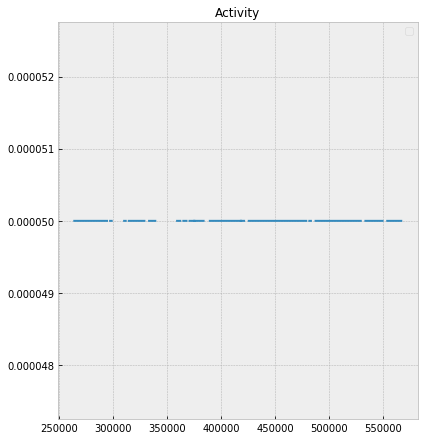

In [18]:
plt.plot(np.array(data['f28']))
plt.legend(loc=0)
plt.tight_layout()
plt.title("Activity", fontsize=12)

No handles with labels found to put in legend.


Text(0.5, 1, 'Activity')

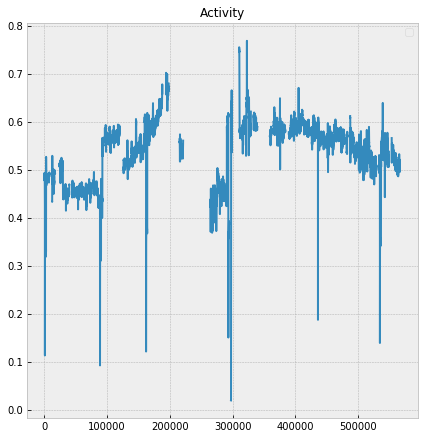

In [19]:
plt.plot(np.array(data['f25']))
plt.legend(loc=0)
plt.tight_layout()
plt.title("Activity", fontsize=12)

No handles with labels found to put in legend.


Text(0.5, 1, 'Activity')

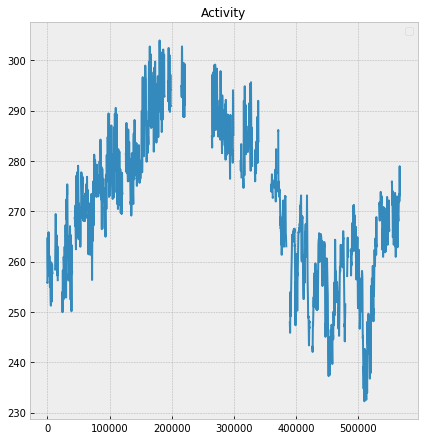

In [20]:
plt.plot(np.array(data['f42']))
plt.legend(loc=0)
plt.tight_layout()
plt.title("Activity", fontsize=12)

No handles with labels found to put in legend.


Text(0.5, 1, 'Activity')

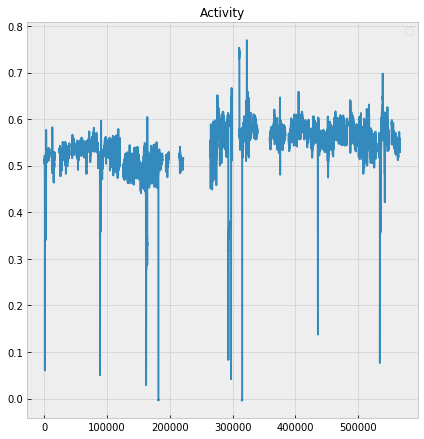

In [21]:
plt.plot(np.array(data['f9']))
plt.legend(loc=0)
plt.tight_layout()
plt.title("Activity", fontsize=12)

No handles with labels found to put in legend.


Text(0.5, 1, 'Activity')

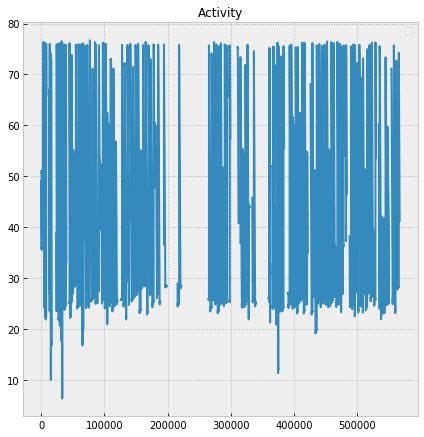

In [22]:
plt.plot(np.array(data['f0']))
plt.legend(loc=0)
plt.tight_layout()
plt.title("Activity", fontsize=12)

In [23]:
data.keys()

Index(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10',
       'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20',
       'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30',
       'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40',
       'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50',
       'f51', 'f52', 'f53', 'f54', 'f55'],
      dtype='object')

No handles with labels found to put in legend.


Text(0.5, 1, 'Activity')

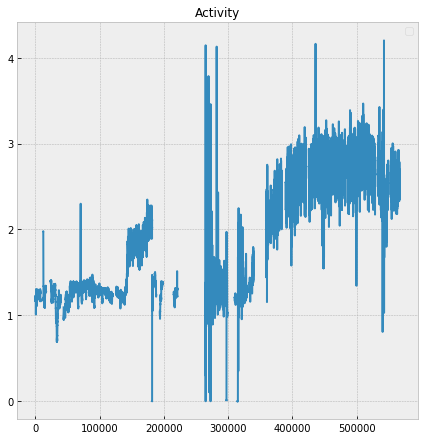

In [24]:
plt.plot(np.array(data['f8']))
#plt.plot(np.array(data['f14']))
#plt.plot(np.array(data['f14'].rolling(period).aggregate(agg)))
plt.legend(loc=0)
plt.tight_layout()
plt.title("Activity", fontsize=12)

In [25]:
drp = ['f28','f25','f42']
#drp = ['f28','f25', 'f42', 'f9', 'f0', 'f17', 'f8', 'f21', 'f39', 'f38', 'f26', 'f13', 'f49', 'f11',
# 'f44', 'f10', 'f16', 'f22', 'f18', 'f40', 'f48', 'f29']
data.drop(drp, axis=1, inplace=True)

Text(0.5, 1, 'Activity')

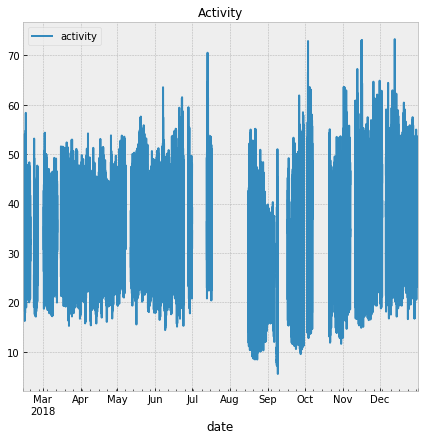

In [26]:
train_targets["activity"].plot()
plt.legend(loc=0)
plt.tight_layout()
plt.title("Activity", fontsize=12)

Text(0.5, 1, 'Atactic fraction')

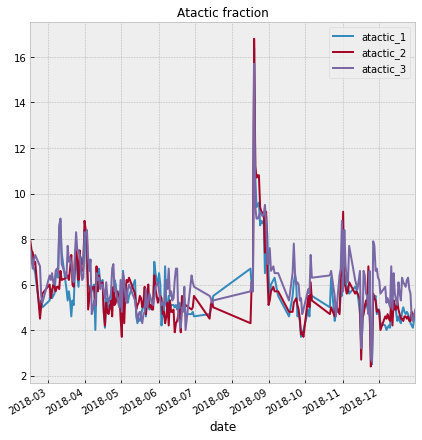

In [27]:
ACOLS = ["atactic_1", "atactic_2", "atactic_3"]

train_targets.loc[train_targets[ACOLS].notnull().all(axis=1), ACOLS].plot()
plt.legend(loc=0)
plt.tight_layout()
plt.title("Atactic fraction", fontsize=12)

In [28]:
full_data = data

In [29]:
activity_data = train_targets[["activity"]].join(full_data.shift(6, freq="H"))
activity_data = activity_data[activity_data.notnull().all(axis=1)]

In [30]:
%%time
period = '0.1H'
agg = 'mean'
activity_data = activity_data.rolling(period).aggregate(agg)
full_data = full_data.rolling(period).aggregate(agg)

Wall time: 3.37 s


In [31]:
tr_data = activity_data[:"2018-10-13"]
cv_data = activity_data["2018-10-14":]

In [32]:
print(f"MAPE (last known value, cross-validation set): {100 * mape(cv_data['activity'], tr_data['activity'].iloc[-1]):.2f}%")
print(f"MAPE (median, cross-validation set): {100 * mape(cv_data['activity'], tr_data['activity'].median()):.2f}%")

MAPE (last known value, cross-validation set): 8.69%
MAPE (median, cross-validation set): 12.25%


In [33]:
naive_baseline = activity_test_target.copy()
naive_baseline["rubber"] = tr_data['activity'].iloc[-1]
#naive_baseline.to_csv("activity_naive_baseline.csv")

In [34]:
center, scale = tr_data.iloc[:, 1:].mean().values, tr_data.iloc[:, 1:].std().values
trn = (tr_data.iloc[:, 1:].values - center)/scale
cvn = (cv_data.iloc[:, 1:].values - center)/scale

In [35]:
test_activity_data = activity_test_target.join(full_data.shift(6, freq="H")).ffill()

In [36]:
target = activity_data.activity
activity_data.drop('activity', axis=1, inplace=True)
#activity_data.head(2)

In [37]:
#test_activity_data.head(2)

In [38]:
def LGB_kfold(data, test_data, labels, W, param, n_splits, categorical_feature):
    kf = KFold(n_splits=n_splits)
    
    oof_pred = []
    oof_trashold = []
    oof_metric_native = []
    oof_metric_trashold = []
    
    val_pred = []
    val_W = []
    val_metric_native = []
    val_metric_trashold = []
        
    test_pred = [] 
    test_pred_trashold = []
    i = 0
    for fold, (train_indx, val_indx) in enumerate(kf.split(labels)):
        print("Fold {}".format(fold+1))
        train_set = lgb.Dataset(data.iloc[train_indx], label=labels.iloc[train_indx])
        val_set = lgb.Dataset(data.iloc[val_indx], label=labels.iloc[val_indx])
        model = lgb.train(param, train_set, valid_sets=val_set, 
                          verbose_eval=500) #, categorical_feature=categorical_feature)
        print('OOF:')
        oof_pred.append(model.predict(data, num_iteration=model.best_iteration))

        print('OOF native')
        oof_metric_native_v = 100 * mape(oof_pred[i], np.array(target))
        print(oof_metric_native_v)
        oof_metric_native.append(oof_metric_native_v)
                          
        #print('OOF trashold')
        #trashold = best_trashhold (oof_pred[i], W)
        #oof_trashold.append(trashold_apply (oof_pred[i], trashold))
        #oof_metric_trashold.append(metric_trashold_p (oof_pred[i], W, trashold))
                          
        print('Validation:')
        val_pred.append(model.predict(data.iloc[val_indx], num_iteration=model.best_iteration)) 
        #val_W.append(W[val_indx])
        val_metric_native.append(100 * mape(val_pred[i], np.array(target[val_indx])))
        print(val_metric_native[i])
        #val_metric_native.append(metric_native (val_pred[i], W[val_indx]))
        #val_metric_trashold.append(metric_trashold_p (val_pred[i], W[val_indx], trashold))
        
        test_pred.append(model.predict(test_data, num_iteration=model.best_iteration))
        #test_pred_trashold.append(trashold_apply(test_pred[i],trashold))
        
        
        
        i +=1
    print('=======MEAN======')
    print('mean val_metric_native', np.mean(val_metric_native))
    #print('mean val_metric_trashold', np.mean(val_metric_trashold))
    print('mean oof_metric_native', np.mean(oof_metric_native))
    #print('mean oof_metric_trashold', np.mean(oof_metric_trashold))
    
    R = {
        #'val_pred': val_pred,
        #'val_W':val_W,
        #'val_metric_native': val_metric_native,
        'oof_pred': oof_pred,
        #'oof_trashold': oof_trashold,
        'oof_pred_mean': np.mean(oof_pred,axis=0),
        #'oof_trashold_mean': np.mean(oof_trashold,axis=0),
        'test_pred': test_pred,
        #'test_pred_trashold': test_pred_trashold,
        'test_pred_mean': np.mean(test_pred,axis=0),
        #'test_pred_trashold_mean': np.mean(test_pred_trashold,axis=0),
        

    }
    
    return R


In [39]:
param = {'application': 'regression',
          'boosting': 'gbdt',
          'metric': 'mape',
          'num_leaves': 80,
          'max_depth': 9,
          'learning_rate': 0.02,
          'bagging_fraction': 0.85,
          'feature_fraction': 0.8,
          'min_split_gain': 0.02,
          'min_child_samples': 150,
          'min_child_weight': 0.02,
          'lambda_l2': 0.05,
          'verbosity': -1,
          'data_random_seed': 17,
          'early_stop': 100,
          'verbose_eval': 100,
          'num_rounds': 2000}

In [40]:
print(activity_data.shape)
print(target.shape)
print(test_activity_data.shape)

(300759, 53)
(300759,)
(85891, 53)


In [41]:
data = activity_data
labels = target
test_data = test_activity_data
W = []
n_splits = 10
categorical_feature = []

In [42]:
data.keys()

Index(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10',
       'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20',
       'f21', 'f22', 'f23', 'f24', 'f26', 'f27', 'f29', 'f30', 'f31', 'f32',
       'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f43',
       'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53',
       'f54', 'f55'],
      dtype='object')

In [43]:
data.shape

(300759, 53)

In [44]:
%%time
LGB_result = LGB_kfold(data, test_data, labels, W, param, n_splits, categorical_feature)

Fold 1


D:\Programs\x64\Anaconda_3_2019_07\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[500]	valid_0's mape: 0.0836912
[1000]	valid_0's mape: 0.0833171
[1500]	valid_0's mape: 0.0835824
[2000]	valid_0's mape: 0.0838712
OOF:
OOF native
3.622044805442274
Validation:
7.611589693937987
Fold 2
[500]	valid_0's mape: 0.0637893
[1000]	valid_0's mape: 0.0640244
[1500]	valid_0's mape: 0.0641358
[2000]	valid_0's mape: 0.0641229
OOF:
OOF native
3.4435655602865998
Validation:
6.151229923756183
Fold 3
[500]	valid_0's mape: 0.060402
[1000]	valid_0's mape: 0.0604562
[1500]	valid_0's mape: 0.0605842
[2000]	valid_0's mape: 0.0607015
OOF:
OOF native
3.4485014963585052
Validation:
6.010461202108725
Fold 4
[500]	valid_0's mape: 0.0631746
[1000]	valid_0's mape: 0.0639011
[1500]	valid_0's mape: 0.0643764
[2000]	valid_0's mape: 0.0647001
OOF:
OOF native
3.519812117822204
Validation:
6.686420537024198
Fold 5
[500]	valid_0's mape: 0.0687875
[1000]	valid_0's mape: 0.0687059
[1500]	valid_0's mape: 0.068641
[2000]	valid_0's mape: 0.068629
OOF:
OOF native
3.4627603963490987
Validation:
6.7343324148603

In [45]:
#MAPE (last known value, cross-validation set):
#100 * mape(cv_data['activity'], tr_data['activity'].iloc[-1])
100 * mape(LGB_result['oof_pred_mean'], np.array(target))

3.311991576217029

In [46]:
100 * mape(LGB_result['oof_pred_mean']*2-LGB_result['oof_pred_mean'].mean(), np.array(target))

10.92997033103003

In [47]:
#f"MAPE (median, cross-validation set):
100 * mape(LGB_result['oof_pred_mean'], np.median(np.array(target)))

9.316784440015319

In [48]:
#sample_submit = pd.read_csv('../input/sibur-csv/activity_naive_baseline1.csv')

In [49]:
period = '1H'
agg = 'mean'
submit = activity_test_target.copy()
submit["activity"] = LGB_result['test_pred_mean']
#submit = submit.rolling(period).aggregate(agg)

In [50]:
submit.to_csv("submit_model4.csv")

In [51]:
LGB_result['oof_pred_mean'].shape

(300759,)

In [52]:
#target

In [53]:
#data.head(1)

In [54]:
#data.keys()

In [55]:
oof_pred = pd.DataFrame(target)
oof_pred['oof'] = LGB_result['oof_pred_mean']

In [56]:
#oof_pred['oof']

In [57]:
oof_RM = oof_pred.rolling(period).aggregate(agg)

In [58]:
100 * mape(np.array(oof_pred['oof']), np.array(target))

3.311991576217029

In [59]:
100 * mape(np.array(oof_RM['oof']), np.array(target))

4.8075544440323625

No handles with labels found to put in legend.


Text(0.5, 1, 'Activity')

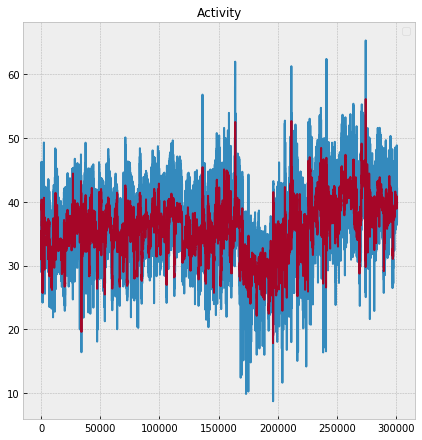

In [60]:
A = 0
B = -1
plt.plot(np.array(target)[A:B])
plt.plot(np.array(oof_RM['activity'][A:B]))

#plt.plot(np.array(data['f45'])[A:B])

plt.legend(loc=0)
plt.tight_layout()
plt.title("Activity", fontsize=12)

In [61]:
100 * mape(oof_RM['oof'].fillna(1), np.array(target))

4.8075544440323785

In [62]:
oof_RM.keys()

Index(['activity', 'oof'], dtype='object')

No handles with labels found to put in legend.


Text(0.5, 1, 'Activity')

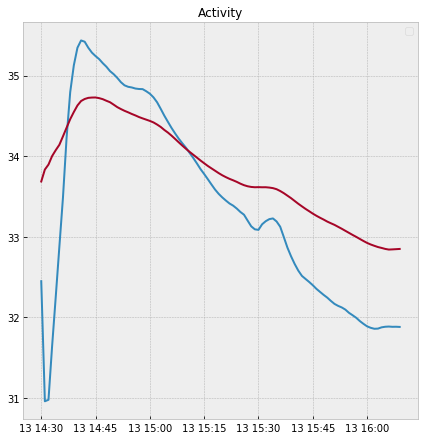

In [63]:
A = 0
B = 100
plt.plot(oof_RM['activity'][A:B])
plt.plot(oof_RM['oof'][A:B])
#plt.plot(np.array(data['f45'])[A:B])

plt.legend(loc=0)
plt.tight_layout()
plt.title("Activity", fontsize=12)

No handles with labels found to put in legend.


Text(0.5, 1, 'Activity')

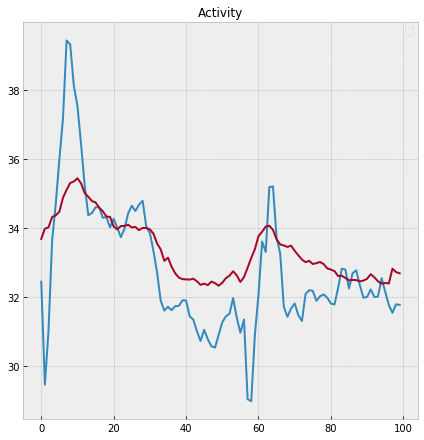

In [64]:
A = 0
B = 100
plt.plot(np.array(target)[A:B])
plt.plot(LGB_result['oof_pred_mean'][A:B])
#plt.plot(np.array(data['f45'])[A:B])

plt.legend(loc=0)
plt.tight_layout()
plt.title("Activity", fontsize=12)

In [65]:
center, scale = np.array(target).mean(), np.array(target).std()
print (center, scale)
#trn = (tr_data.iloc[:, 1:].values - center)/scale
#cvn = (cv_data.iloc[:, 1:].values - center)/scale

35.580507440576866 4.743807678191647


No handles with labels found to put in legend.


Text(0.5, 1, 'Activity')

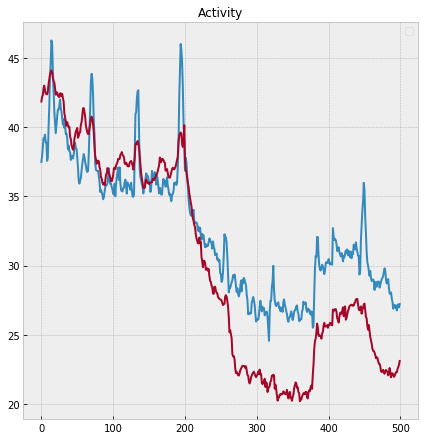

In [66]:
A = 500
B = 1000
plt.plot(np.array(target)[A:B])
plt.plot(LGB_result['oof_pred_mean'][A:B]*2-LGB_result['oof_pred_mean'].mean())

plt.legend(loc=0)
plt.tight_layout()
plt.title("Activity", fontsize=12)

No handles with labels found to put in legend.


Text(0.5, 1, 'Activity')

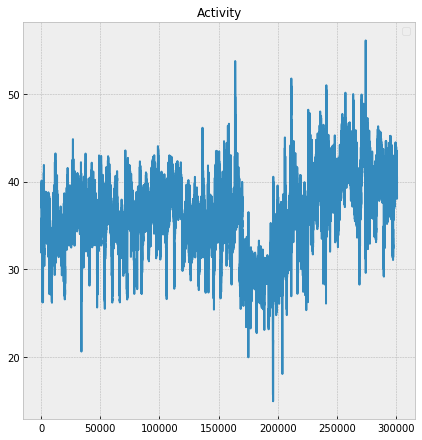

In [67]:
plt.plot(LGB_result['oof_pred_mean'])
plt.legend(loc=0)
plt.tight_layout()
plt.title("Activity", fontsize=12)

In [68]:
train_targets["activity"].shape


(463058,)

Text(0.5, 1, 'Activity')

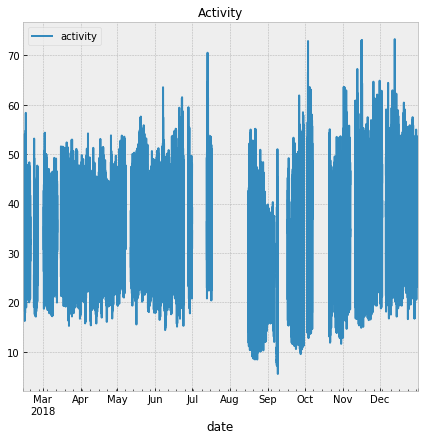

In [69]:
train_targets["activity"].plot()
plt.legend(loc=0)
plt.tight_layout()
plt.title("Activity", fontsize=12)

In [70]:
train_targets.shape

(463058, 4)

In [71]:
LGB_result['oof_pred_mean'].shape

(300759,)

Text(0.5, 1, 'Activity')

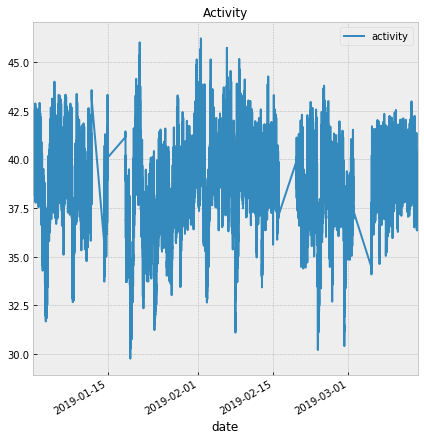

In [72]:
submit["activity"].plot()
plt.legend(loc=0)
plt.tight_layout()
plt.title("Activity", fontsize=12)

In [73]:
#submit

In [74]:
#naive_baseline

In [75]:
#sample_submit